# Simple Imitation Learning

In [1]:
import os
import cv2
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

from models.mlp import MLP
from models.autoencoders import AE
from trainers.standard import train
from utils_.utils import from_sim_get_poses_n_gripper
from utils_.plotting import plot_waypoints_and_initial_image
from utils_.waypoint_extraction import pickplace_task_waypoints

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device Name: {torch.cuda.get_device_name(device)}" if device.type == "cuda" else "Using cpu")
DATA_PATH = "./datasets/sim_recs"
IMAGE_RESIZE = 256
LATENT_DIM = 6
AE_PATH = "./logs/models/autoencoder_2024-10-21_15:24/pth/epoch_2000.pth"
L2W_PATH = "./logs/models/mlp_2024-10-21_16:47/pth/epoch_2000.pth"
dirs = os.listdir(DATA_PATH)
im_paths = [f"{DATA_PATH}/{dir}/images/0000.jpg" for dir in dirs]

Device Name: NVIDIA GeForce RTX 3090


In [3]:
image_encoder = AE(latent_dim=LATENT_DIM).to(device=device)
image_encoder.load_state_dict(torch.load(AE_PATH, map_location=device))

# Create the input data: latent representation of initial scene images
X = []
for im_path in tqdm(im_paths):
    image = cv2.imread(im_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMAGE_RESIZE, IMAGE_RESIZE))
    image = image/255.0
    image = np.transpose(image, (2, 0, 1))  # HWC to CHW
    latent = image_encoder.encode(torch.Tensor(np.array([image])).to(device))
    X.append(latent[0].cpu().detach().numpy())

X = np.array(X)
print(X.shape)

/tmp/ipykernel_8447/2277165131.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image_encoder.load_state_dict(torch.load(AE_PATH, map_location=device))
100%|██████████| 4

(4911, 6)


In [4]:
dirs = os.listdir(DATA_PATH)

# Create output data: waypoint collections from the paths
ways = []
for ep_path in tqdm(dirs):
    pos, quat, gripper_widths = from_sim_get_poses_n_gripper(f"{DATA_PATH}/{ep_path}/proprioceptives.txt")
    ways.append(pickplace_task_waypoints(pos, gripper_widths))
ways = np.array(ways)

y = ways.reshape(ways.shape[0], -1)
del ways
print(y.shape)

100%|██████████| 4911/4911 [02:52<00:00, 28.51it/s]

(4911, 9)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)

y_pred = ridge_model.predict(X_test)

errors = y_test - y_pred
errors = errors[:, :2]
errors = [np.linalg.norm(e) for e in errors]
mean_error = sum(errors)/len(errors)
devs = [abs(e-mean_error) for e in errors]
dev_error = sum(devs)/len(devs)

print("Avg. dist. from desired point (m): ", mean_error)
print("Avg. dev. from desired point (m): ", dev_error)

Avg. dist. from desired point (m):  0.0822985900856862
Avg. dev. from desired point (m):  0.043837747362527435


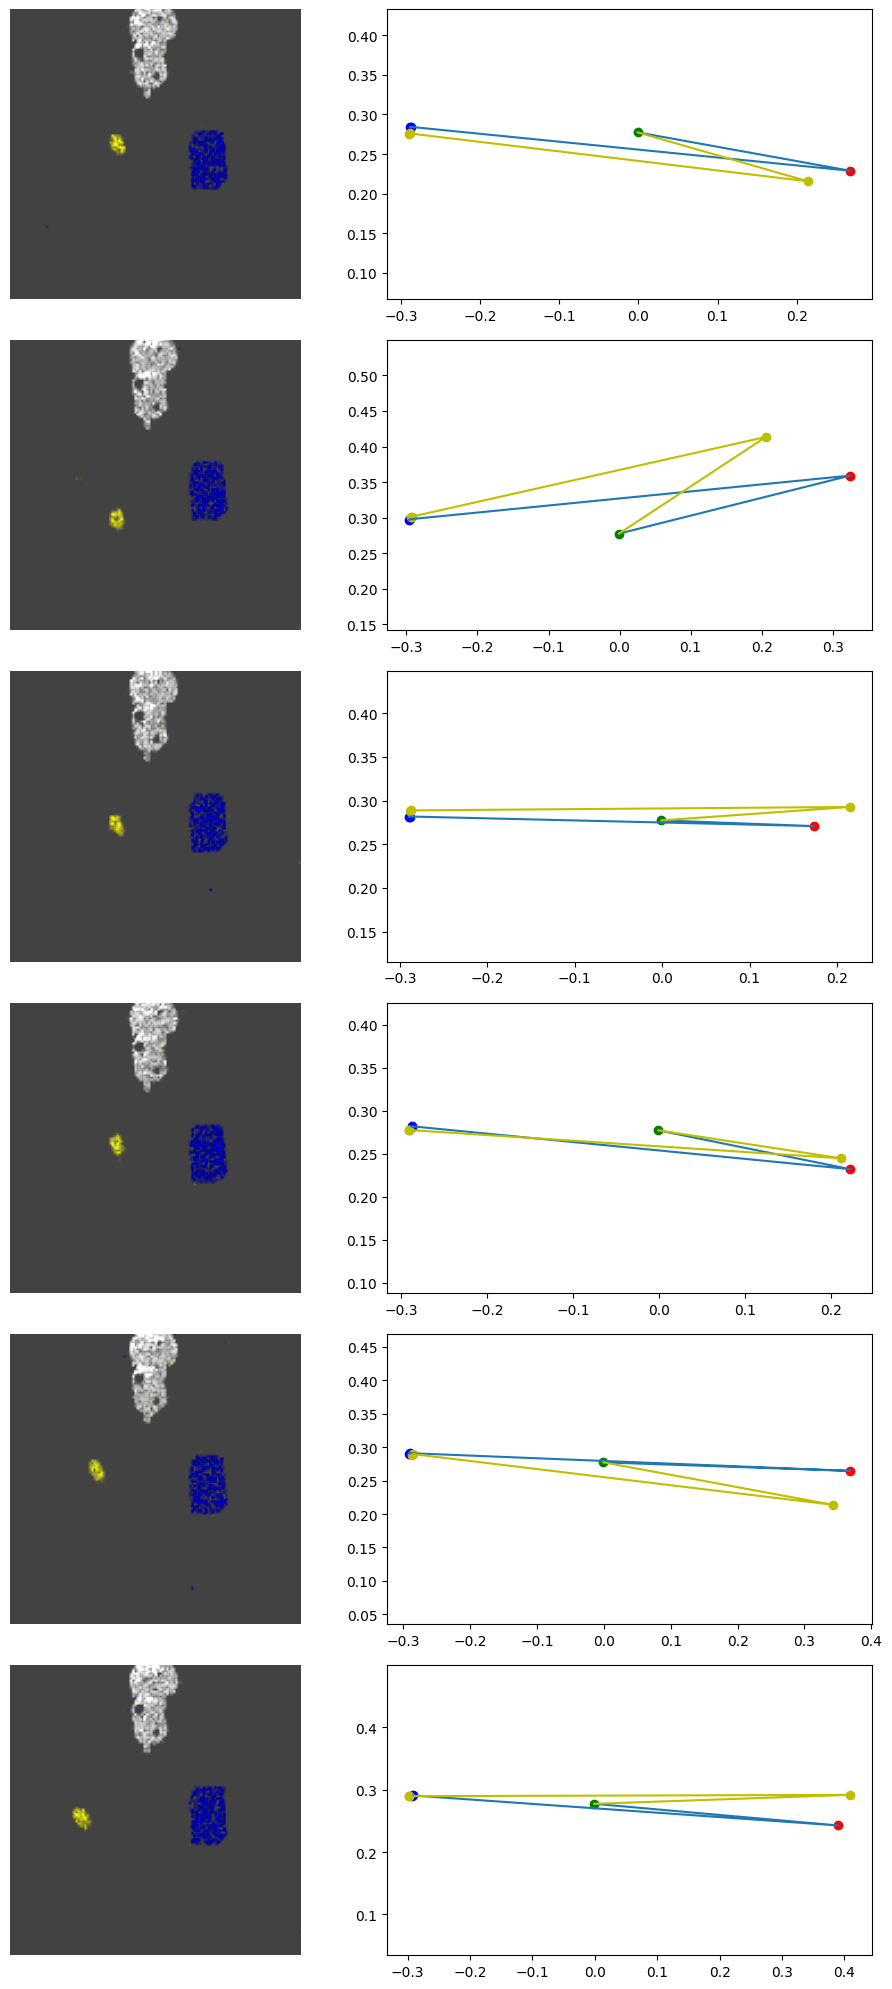

In [6]:
example_count = 6
rand_indices = np.random.choice(list(range(len(X_test))), size=example_count)

latent = X_test[rand_indices]
imgs = image_encoder.decode(torch.Tensor(latent).to(device))
imgs = imgs.detach().cpu().numpy()
imgs = np.maximum(imgs, 0)
imgs = np.minimum(imgs, 1)
imgs = np.transpose(imgs, (0, 2, 3, 1))

target_waypoints = y_test[rand_indices].reshape(6, 3, 3)

pred_waypoints = ridge_model.predict(latent)
pred_waypoints = pred_waypoints.reshape(6, 3, 3)

plot_waypoints_and_initial_image(pred_waypoints, target_waypoints, imgs)

In [7]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.float)
X_val_tensor = torch.tensor(X_test, dtype=torch.float)
y_val_tensor = torch.tensor(y_test, dtype=torch.float)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True)

In [10]:
mlp_model = MLP(X_train.shape[1], y_train.shape[1], hidden_layers=[16, 16, 16]).to(device)
mlp_model.load_state_dict(torch.load(L2W_PATH, map_location=device))
# mlp_model = train(mlp_model, device, train_loader, val_loader, n_epochs=2000, lr=1e-4)

/tmp/ipykernel_8447/3563287611.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp_model.load_state_dict(torch.load(L2W_PATH, map_location=device))


<All keys matched successfully>

In [11]:
y_pred = mlp_model(torch.Tensor(X_test).to(device)).cpu().detach().numpy()

errors = y_test - y_pred
errors = errors[:, :2]
errors = [np.linalg.norm(e) for e in errors]
mean_error = sum(errors)/len(errors)
devs = [abs(e-mean_error) for e in errors]
dev_error = sum(devs)/len(devs)

print("Avg. dist. from desired point (m): ", mean_error)
print("Avg. dev. from desired point (m): ", dev_error)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

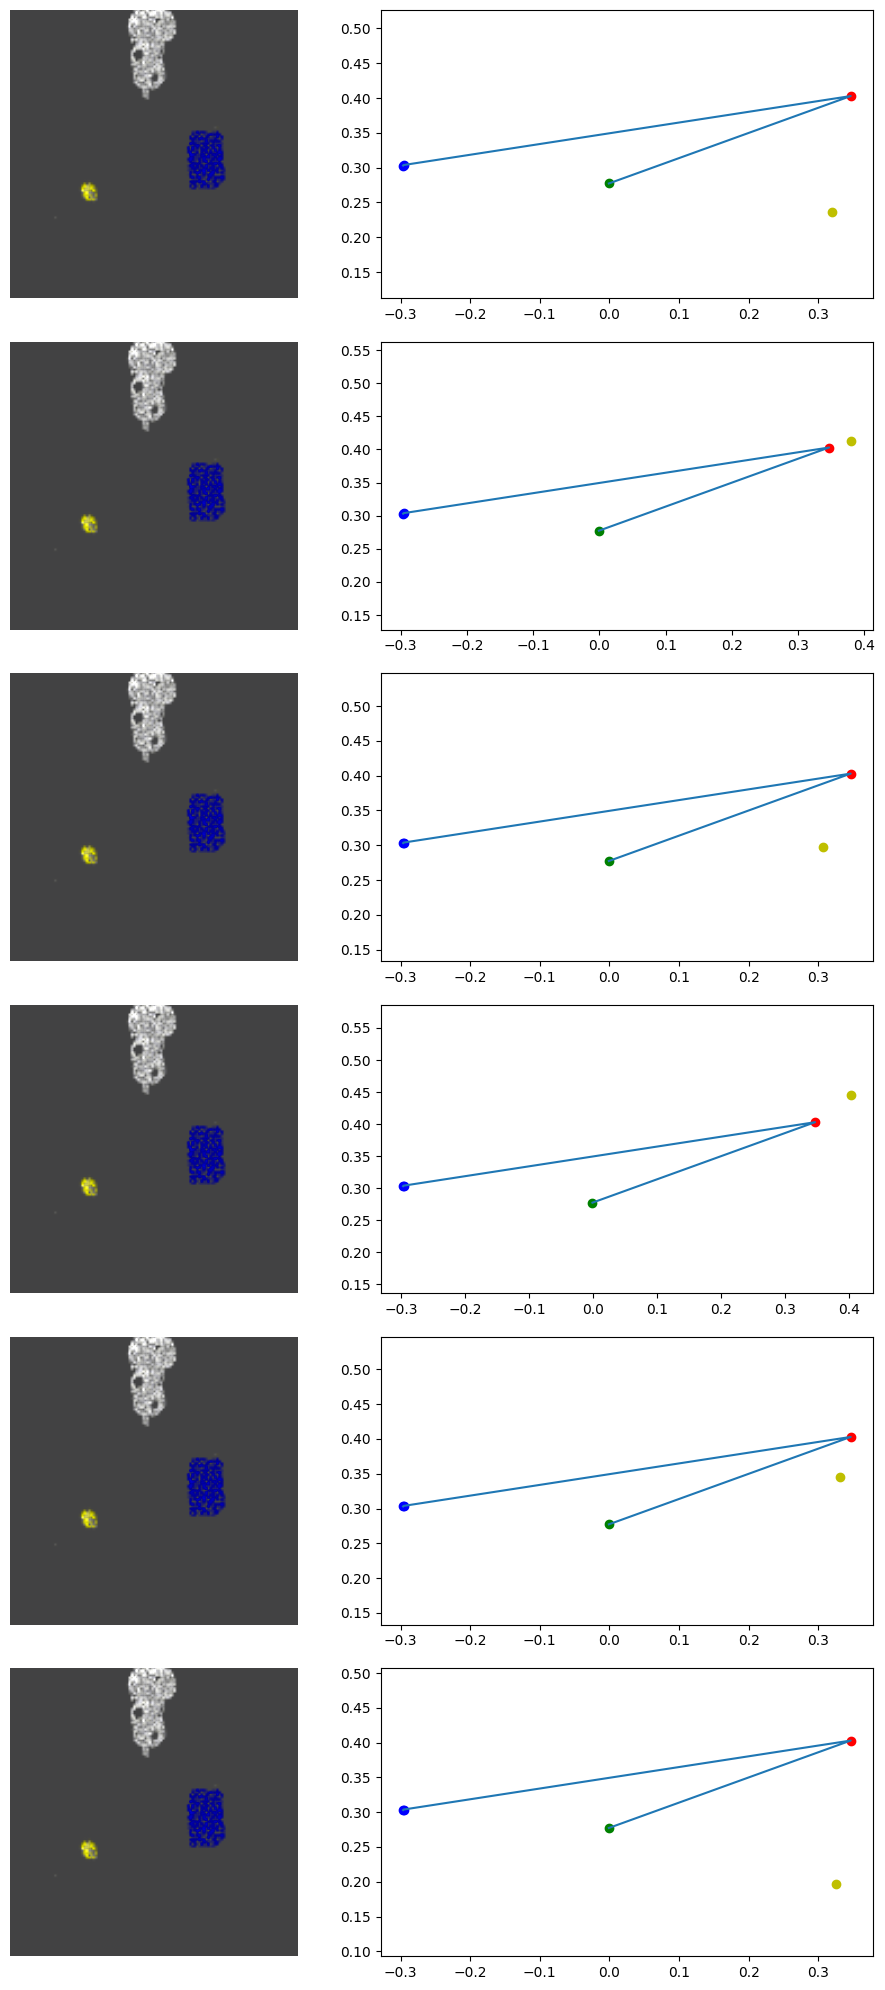

In [11]:
pred_waypoints = mlp_model(torch.Tensor(latent).to(device)).cpu().detach().numpy()
pred_waypoints = pred_waypoints.reshape(6, 3, 3)

plot_waypoints_and_initial_image(pred_waypoints, target_waypoints, imgs)